# TSP's Independence Detection Distributions
### Information and Decision Systems Group<br>University of Chile

Implementation of the TSP's independence detection distributions presented by [Gonzales et al. (2021)](https://arxiv.org/pdf/2110.14122.pdf). 

In [1]:
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from itertools import repeat
sys.path.insert(1, '../src/build')
from TSP import TSP
sys.path.insert(1, './utils')
from distributions import *

NUM_WORKERS = 4

In [2]:
 # Utils
def tsp_experiment(iteration, tsp_params, dist, dist_params):
    l_bn, w_bn, lambdas = tsp_params
    dim, corr, n_samples = dist_params
    _, X, Y, _ = dist(dim, corr, n_samples)
    emis = []
    for l in lambdas:
        l_sizes = []
        l_emis = []
        tsp = TSP(l_bn, w_bn, l)
        for n in samples:
            tsp.grow(np.copy(X[:n], order='F'), np.copy(Y[:n], order='F'))
            if l != 0:
                tsp.regularize()
            l_emis.append(tsp.emi())
        emis.append(l_emis)
    return emis

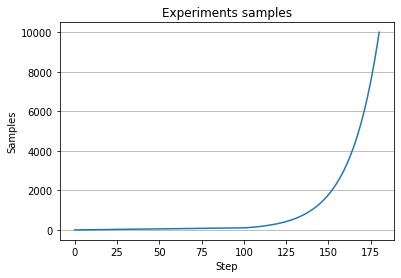

In [3]:
# Number of samples per step
samples = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                    26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 
                    49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 
                    72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 
                    95, 96, 97, 98, 99, 100, 101, 107, 114, 120, 127, 135, 143, 151, 160, 169, 179, 190, 201, 
                    213, 225, 239, 253, 268, 283, 300, 318, 336, 356, 377, 400, 423, 448, 475, 503, 532, 564, 
                    597, 632, 670, 709, 751, 796, 843, 893, 946, 1001, 1061, 1124, 1190, 1260, 1335, 1414, 1498,
                    1586, 1680, 1780, 1885, 1997, 2115, 2240, 2373, 2513, 2662, 2820, 2987, 3164, 3351, 3550, 
                    3760, 3983, 4218, 4468, 4733, 5013, 5310, 5625, 5958, 6311, 6685, 7081, 7500, 7945, 8415, 
                    8914, 9442, 10001])
step_to_samples = dict(zip(range(1, len(samples) + 1), samples))
n_samples = samples[-1]
plt.plot(samples)
plt.title('Experiments samples')
plt.xlabel('Step')
plt.ylabel('Samples')
plt.grid(axis='y')
plt.show()

## Estimated Mutual Information Trajectories

In [4]:
# TSP parameters
l_bn = 0.001
w_bn = 0.1
lambdas = [0.00007500, 0.0001500, 0.0002500, 0.0003500]
# Experimental setting
dist = gaussian_dist
dim = 1
n_iterations = 1000
correlations = [0, 0.3]
# Experiments (parallelized)
results = []
for corr in correlations:
    tsp_params = [l_bn, w_bn, lambdas]
    dist_params = [dim, corr, n_samples]
    pool = mp.Pool(NUM_WORKERS)
    start_time = time.time()
    res = pool.starmap_async(tsp_experiment, list(zip(range(n_iterations), 
                                                      repeat(tsp_params), 
                                                      repeat(dist),
                                                      repeat(dist_params))))
    pool.close()
    pool.join()
    end_time = time.time()
    results.append(np.array(res.get()))
    print("Correlation: {:.1f} | Elapsed Time: {:.2f} [min]".format(corr, (end_time - start_time) / 60))

Correlation: 0.0 | Elapsed Time: 0.68 [min]
Correlation: 0.3 | Elapsed Time: 0.72 [min]


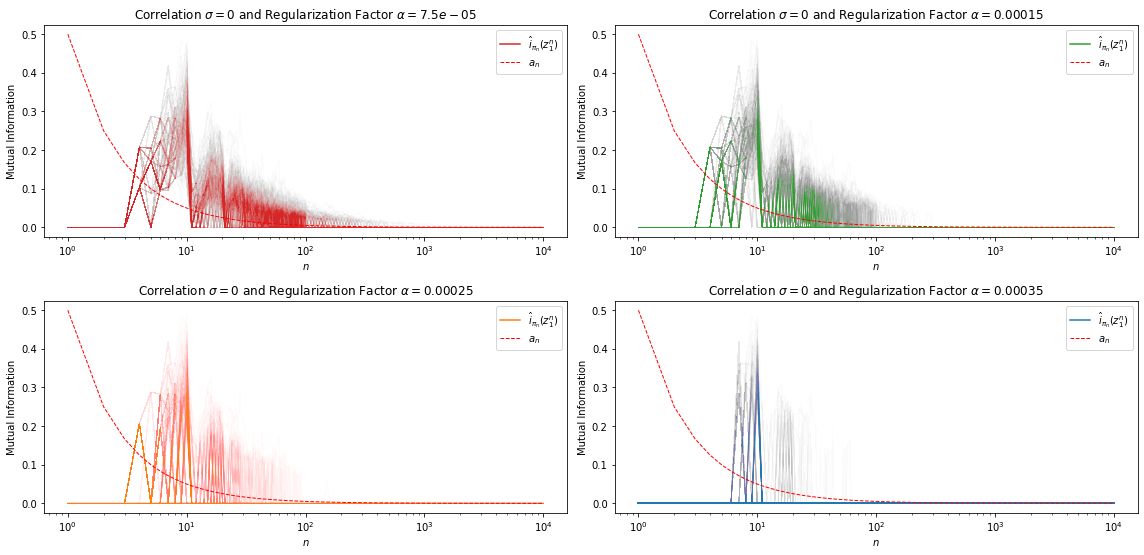

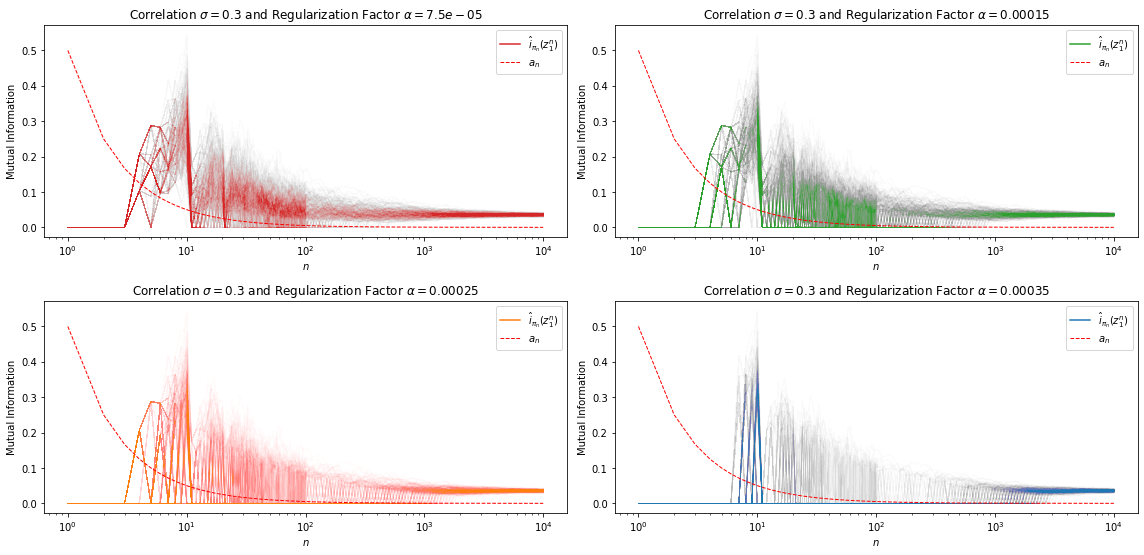

In [5]:
# Decreasing polynomial threshold
K = 0.5
p = 1.0
threshold = (K * samples ** -p)[:results[0].shape[-1]]
# Plots
for l in range(len(correlations)):
    corr = correlations[l]
    data = results[l]
    fig = plt.figure(figsize=(16,15))
    for i in range(data.shape[1]):
        plt.subplot(4,2,i+1)
        for j in range(data.shape[0]):
            plt.plot(samples, data[j,i,:], 
                     color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3-i], alpha=0.005)
        plt.plot([None], [None], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3-i], 
                 label=r'$\hat{i}_{\pi_n}(z_1^n)$')
        plt.plot(samples, threshold, '--', color='red', linewidth=1, label=r'$a_n$')
        plt.xscale('log')
        plt.xlabel(r'$n$')
        plt.ylabel('Mutual Information')
        plt.title(r"Correlation $\sigma={}$ and Regularization Factor $\alpha={}$".format(corr, lambdas[i]))
        plt.legend()
    plt.tight_layout()
    plt.show()

## Detection Time Distributions

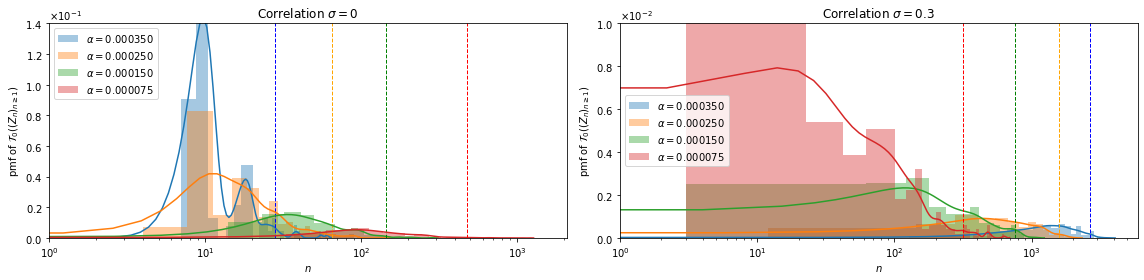

In [6]:
# Utils
max_y = [0.14, 0.01]
colors = ['b', 'orange', 'g', 'r']
lambdas_name = ['7.5\cdot 10^{-5}', '1.5\cdot 10^{-4}', '2.5\cdot 10^{-4}', '3.5\cdot 10^{-4}']

# Independence detection
plt.figure(figsize=(16,4))
for l in range(len(correlations)):
    corr = correlations[l]
    data = results[l]
    results_corr = []
    for i in range(data.shape[1]):
        detection_times = []
        for k in range(data.shape[0]):
            # Decision rule
            if (corr > 0):
                phi = np.where(threshold<=data[k,i,:], 0, 1)
            else:
                phi = np.where(threshold>data[k,i,:], 0, 1)
            aux = np.cumsum(np.flip(phi))
            # Detection time
            if (aux > 0).any():
                detec_time = data.shape[-1] - np.where(aux > 0)[0][0]
                detection_times += [step_to_samples[detec_time]]
        results_corr.append(detection_times)
    # Plot
    plt.subplot(1, 2, l+1)
    for i in range(0, len(results_corr)):
        sns.distplot(results_corr[len(results_corr) - i - 1], 
                     label=r'$\alpha={:f}$'.format(lambdas[len(results_corr) - i - 1], useMathText=False), 
                     kde=True, norm_hist=True, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        plt.axvline(np.percentile(results_corr[len(results_corr) - i - 1], 95, interpolation='higher'), 
                    color=colors[i], linestyle='dashed', linewidth=1)
    plt.xticks(samples)
    plt.xscale("log")
    plt.xlabel(r'$n$')
    plt.ylabel(r'pmf of $\mathcal{T}_0((Z_n)_{n\geq 1})$')
    plt.gca().set_xlim(left=1)
    plt.ylim([0, max_y[l]])
    plt.title(r'Correlation $\sigma={}$'.format(corr))
    plt.legend()
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True, useOffset=True)
plt.tight_layout()
plt.show()